# Read data
Data is available at https://www.analyticsvidhya.com/wp-content/uploads/2016/02/Dataset.rar  
 
Label "Disbursed" is unbalanced  

|Disbursed|Count|
|:--------|:----|
|0.0      |85747|  
|1.0      |1273 |  


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from sklearn.ensemble import GradientBoostingClassifier   

df = pd.read_csv('./data/DataHackathon3x_train.csv', encoding = "ISO-8859-1")

# Data preprocessing

## Feature engineering

In [2]:
df['EMI_Loan_Submitted_Missing'] = df['EMI_Loan_Submitted'].apply(lambda x: 1 if np.isnan(x) else 0)
df['Loan_Amount_Submitted_Missing'] = df['Loan_Amount_Submitted'].apply(lambda x: 1 if np.isnan(x) else 0)
df['Loan_Tenure_Submitted_Missing'] = df['Loan_Tenure_Submitted'].apply(lambda x: 1 if np.isnan(x) else 0)
df['Interest_Rate_Missing'] = df['Interest_Rate'].apply(lambda x: 1 if np.isnan(x) else 0)
df['Processing_Fee_Missing'] = df['Processing_Fee'].apply(lambda x: 1 if np.isnan(x) else 0)
df['Source'] = df['Source'].apply(lambda x: 'others' if x not in ['S122','S133'] else x)
df['Age'] = df['DOB'].apply(lambda x:(date.today() - datetime.strptime(x, '%d-%b-%y').date()).days/365.0)

df['Existing_EMI'] = df['Existing_EMI'].fillna(0)
df['Loan_Amount_Applied'] = df['Loan_Amount_Applied'].fillna(df['Loan_Amount_Applied'].median())
df['Loan_Tenure_Applied'] = df['Loan_Tenure_Applied'].fillna(df['Loan_Tenure_Applied'].median())

In [3]:
df = df.drop(['City', 'DOB', 'EMI_Loan_Submitted', 'Employer_Name', 'Interest_Rate', 'Lead_Creation_Date','Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'LoggedIn', 'Salary_Account', 'Processing_Fee'], axis=1)

## Numerical encoding + One-hot encoding

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encode_cols = ['Device_Type','Filled_Form','Gender','Var1','Var2','Mobile_Verified','Source']
for col in encode_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns = encode_cols)

In [5]:
df.head(10)

,ID,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Var4,Disbursed,EMI_Loan_Submitted_Missing,Loan_Amount_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,ID000002C20,20000,300000.0,5.0,0.0,0,1,0,1,1,...,0,0,0,0,1,1,0,1,0,0
1,ID000004E40,35000,200000.0,2.0,0.0,13,3,0,0,0,...,0,0,0,0,1,0,1,1,0,0
2,ID000007H20,22500,600000.0,4.0,0.0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,ID000008I30,35000,1000000.0,5.0,0.0,10,3,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,ID000009J40,100000,500000.0,2.0,25000.0,17,3,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5,ID000010K00,45000,300000.0,5.0,15000.0,17,3,0,0,0,...,0,0,0,0,0,0,1,0,0,1
6,ID000011L10,70000,6.0,5.0,0.0,0,1,0,1,1,...,0,0,0,0,0,1,0,0,1,0
7,ID000012M20,20000,200000.0,5.0,2597.0,3,3,0,1,0,...,0,0,0,0,0,0,1,0,0,1
8,ID000013N30,75000,0.0,0.0,0.0,13,5,0,0,0,...,1,0,0,0,0,0,1,1,0,0
9,ID000014O40,30000,300000.0,3.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [6]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x not in ['Disbursed', 'ID']]
X = df[features]
Y = df['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=4)

# Default Gradient Boosting Model
* Use default setting
* 3 evaluation metrics: 1) accuracy; 2) f1-score; 3) AUC score
* performance on training and testing set


## Default model performance
* poor F1 and AUC socre
* give us the baseline

In [7]:
from sklearn.ensemble import GradientBoostingClassifier     # GBM algorithm
from sklearn import metrics

gbm = GradientBoostingClassifier(random_state=10)
gbm.fit(X_train, y_train)

def evaluation(gbm, X_train, X_test, y_train, y_test):
    y_train_pred = gbm.predict(X_train)
    y_train_predprob = gbm.predict_proba(X_train)[:,1]
    y_test_pred = gbm.predict(X_test)
    y_test_predprob = gbm.predict_proba(X_test)[:,1]
    print("Train Accuracy: %.4f" % metrics.accuracy_score(y_train.values, y_train_pred))
    print("Train AUC score: %.4f\n" % metrics.roc_auc_score(y_train.values, y_train_predprob))
    print("Test Accuracy: %.4f" % metrics.accuracy_score(y_test.values, y_test_pred))
    print("Test AUC score: %.4f" % metrics.roc_auc_score(y_test.values, y_test_predprob))

evaluation(gbm, X_train, X_test, y_train, y_test)

Train Accuracy: 0.9853
Train AUC score: 0.8658

Test Accuracy: 0.9859
Test AUC score: 0.8364


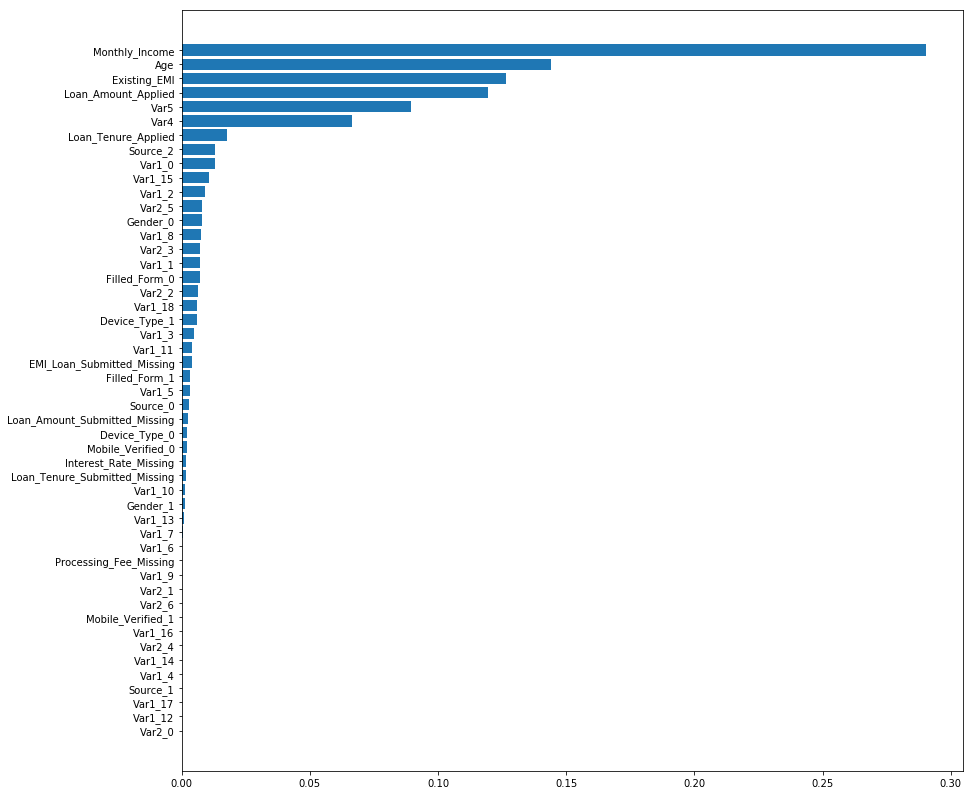

In [9]:
def plot_featureImportance(gbm):
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(1,1, figsize=(14,14))
    feature_importance = pd.Series(gbm.feature_importances_, features).sort_values(ascending=True)
    ax.barh(feature_importance.index, feature_importance.values)
    #ax.set_xticks(rotation=90)
    plt.show()

plot_featureImportance(gbm)

# Hyper Tuning Graient Boosting Model

## Important parameters
* Tree-specific parameters
* Boosting parameters
* Miscellaneos parameters

### Tree-specific parameters
1. `min_samples_split`
    * minimum # of samples required for splitting a node
    * higher value prevents overfitting
    * too high value lead to under-fitting  
<br />  
  
  
2. `min_samples_leaf`
    * minimum # of samples required in a leaf (a terminal node)
    * control overfitting similar to `min_sample_split`
    * lower values should be chosen for imbalnced classification problem  
<br />      
  
  
3. `min_weight_fraction_leaf`
    * an alternative of #2, only one of `min_samples_leaf` and `min_weight_fraction_leaf` should be defined
    * a minimum fraction of samples requierd in a leaf  
<br />
  
  
4. `max_depth`
    * maximum depth of a tree
    * lower depth wll prevent over-fitting
    * a hyper tuning parameter
    
    <br />

5. `max_leaf_nodes`
    * an alternative to `max_depth`. If it is defined, `max_depth` will be ignored
    * maximum # of leaves in a tree. For binary tree, it equals to 2^max_depth
    
    <br />
    
6. `max_features`
    * the max # of features to consider while searching for a best split. These will be random selected
    * as a thumb rule, `max_features` = $\sqrt{n}$, where $n$ is the total number of features
    * higher value leads to overfitting
    <br /><br /><br />

7. `min_impurity_split`
    * threshold for early stopping in tree growth
    * a node will split if its impurity is aboe the threshold, otherwise it is a leaf
    <br /><br /><br />
    
8. `min_impurity_decrease`
    * a node will be split if this split induces a decrease of impurity greater than this value
    <br /><br /><br />
    
9. `random_state`
    * the seed used by random number generator
    * it is important for parameter tuning. If we do not fix the random number, then we'll have different outcomes for subsequent runs on the same parameters and it bcomes difficult to compare models
    * In type tuning, generally we fix the random state.
    <br /><br /><br />
    
10. `presort`
    * whether to presort the data to speed up splits
    <br /><br /><br />

### Boosting parameters
1. `learning_rate`
    * control the learning rate of change in the estimates
    * lower values make model more robust but also more computational expense
    <br /><br /><br />
    
2. `n_estimators`
    * the total # of sequential trees to be modeled
    * higher # of trees can still lead to overfitting
    * a recommended hyper tuning parameter
    * there is a trade-off betwen `learning_rate` and `n_estimators`
    <br /><br /><br />
    
3. `subsample`
    * The fraction of examples to be selected for each tree. Selection is done by random sampling
    * recommend values slightly less than 1, making the model robust by reducing the variance
    * typical values ~0.8
    * a recommended hyper tuning parameter
    <br />
    <br />
    <br />
       
### Miscellaneos parameters
1. `loss`
    * the loss function to be minimized, either 'deviance (default)' or 'exponential'
    * deviance loss is logistic regresion loss function  
      for binomial case, it is Binomial Deviance Loss Function (it could be expanded into MultinomialDeviance)
      $$Loss = yz - \log(1+e^z)$$  
    
    Derivation:
    <br /><br />
    $$
    \begin{align}
     Loss &= y\log(p) + (1-y)\log(1-p) \\
         &= y\log \left({p\over 1-p}\right) + \log(1-p)
    \end{align}  
    $$
    Since $$p = {e^z \over 1+e^z}\;\;\;\; 1-p = {1 \over 1 + e^z}$$  
    
    therefore
    $$
    \begin{align}
    Loss &= yz - \log(1+e^z)
    \end{align}
    $$  
    
    (Additionally, gradient descent)
    $$
    \frac{\partial L}{\partial z} = y - \frac{e^z}{1+e^z} = y - p
    $$
    <br />
    * exponential loss recovers AdaBoost algorithm 
    $$
    Loss = {1\over m} \sum_{i=1}^m \exp\left(-y_i F(x_i)\right)
    $$
    where
    $$F(x) = \sum_{t=1}^T \alpha_t h_t(x)$$
    with $\alpha$ beging assigned weight, and $h_t(x)$ being a weak hypothesis $h_t$: $\mathcal{H} \rightarrow \{-1, +1 \}$
    <br /><br /><br />
    
2. `init`
    * this can be used if we hae another model whose outcome is to be used as the initial estimates for GBM
    <br /><br /><br />
    
3. `warm_start`
    * this option is for advanced applications
    * allow fit additional trees on previous fits of a model, which can save a lot of time
    <br /><br /><br />


In [10]:
from sklearn.model_selection import GridSearchCV
tuning_param = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [500,1000,1500],
    'max_features': [5,10,16],
    'learning_rate': [0.1,0.05,0.01],
    'loss': ['deviance', 'exponential'],
    'n_estimators':[50,60,70],
    'subsample':[0.7, 0.8, 0.9]
    }

gbm = GradientBoostingClassifier()
gs = GridSearchCV(estimator=gbm, param_grid=tuning_param, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [5, 10, 15], 'min_samples_split': [500, 1000, 1500], 'max_features': [5, 10, 16], 'learning_rate': [0.1, 0.05, 0.01], 'loss': ['deviance', 'exponential'], 'n_estimators': [50, 60, 70], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
print("Best Cross-validation grid score: %.5f" % gs.best_score_)
print("Best Cross-validation grid parameters: {}".format(gs.best_params_))

Best Cross-validation grid score: 0.83807
Best Cross-validation grid parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10, 'max_features': 10, 'min_samples_split': 1000, 'n_estimators': 50, 'subsample': 0.7}


In [12]:
gscv_gbm = gs.best_estimator_
evaluation(gscv_gbm, X_train, X_test, y_train, y_test)

Train Accuracy: 0.9850
Train AUC score: 0.9188

Test Accuracy: 0.9862
Test AUC score: 0.8392


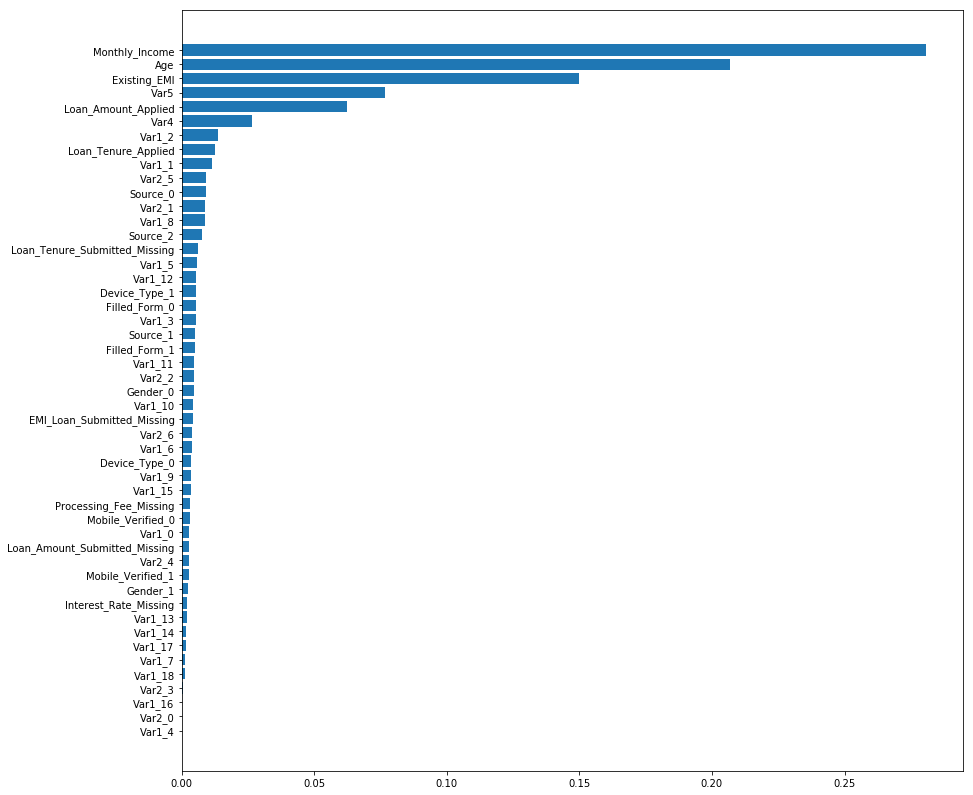

In [13]:
plot_featureImportance(gscv_gbm)